<a href="https://colab.research.google.com/github/frank-895/pasta_detector/blob/main/pasta_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Deep Learning Pasta Identifier
This notebook will be generating and exporting an AI model for identifying pasta shapes (from the top 8 most popular). fastai will be utilised, as a high-level deep learning library, to assist with my learning. The exported model will then be used in a gradio web application hosted via huggingface.


In [10]:
%%capture
!pip install fastbook
!pip install duckduckgo-search

In [11]:
from fastbook import *
from duckduckgo_search import DDGS
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *
from fastai.vision.widgets import *

def search_images(keywords, max_images=100):
  """This function uses the duckduckgo API to return links to a specified number of images 'max_images' using 'keywords' for the search"""
  return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')

We have a function that will search duckduckgo. For the top 10 most mentioned pasta shapes online, we will download 100 photos to train/verify the model with.

In [12]:
# define the pasta types the AI model will detect
pasta_types = ['spaghetti', 'penne', 'fusilli', 'farfalle', 'fettuccine', 'macaroni', 'orecchiette', 'gnocchi']
path = Path('pastas')

# download the 100 images locally
for pasta in pasta_types:
  dest = (path/pasta)
  dest.mkdir(exist_ok=True, parents=True)
  download_images(dest, urls=search_images(f'{pasta} pasta'))


It is important to remove any failed images to prevent them from breaking the model.

In [13]:
# we will remove the failed images
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed) # to check how many failed (out of 800)

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


6

To fit the model, we use DataLoaders - an object containing the training set and validation set. DataBlock is a flexible API from fastai to to define a data pipeline (how data is loaded, processed and split). DataLoaders is the object responsible for feeding batches of data to the model during training.

- `blocks` defines input type and output type- we are mapping images to categories
- `get_items` defines how to find all inputs to our model
- `splitter` how to split between training and validation
- `get_y` the name of the parent of each file (i.e., the name of the folder they're in)
- `item_tfms` we use `RandomResizedCrop` to take a different part of each image on each epoch to improve the model without increasing the dataset. Because we are feeding the model batches of images (tensors) we need to make sure the images are the same size.
- `batch_tfms` we augment (create random variations of input data) batches of images, leveraging parallel processing capabilities of the GPUs. Again, improving the model without increasing the dataset.

In [14]:
# now we will create the data loaders object for the model
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.3), # model benefits from different parts of image
    batch_tfms=aug_transforms() # to improve the model without increasing the size of the dataset
).dataloaders(path)

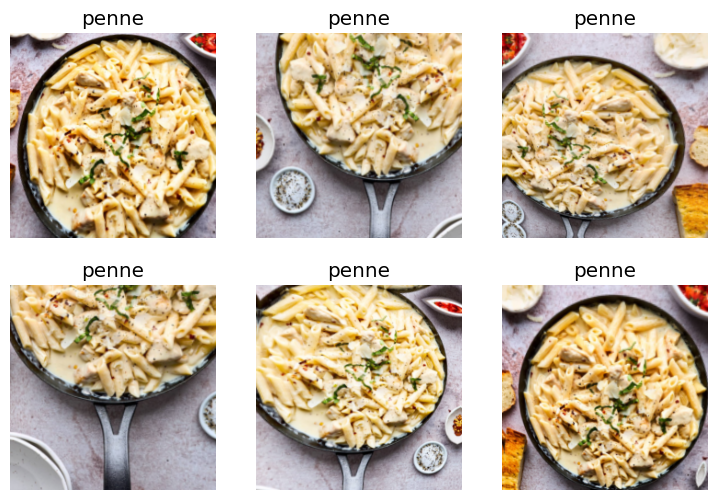

In [15]:
# we can inspect our training photos
dls.train.show_batch(max_n=6,unique=True)

Now we are ready to train our model by creating a learner object. `vision_learner` will set up a learner for image classification and we will use resnet18 which a pretrained model with 18 layers designed for image classification. We will use `fine_tune` to adapt the model for our purposes and `error_rate` as the metric to evaluate its performance on each epoch (2).

In [16]:
import warnings
warnings.filterwarnings("ignore", message="Palette images with Transparency expressed in bytes should be converted to RGBA images")

learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,2.482268,1.011465,0.354790,10:40


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


epoch,train_loss,valid_loss,error_rate,time
0,1.088105,0.642618,0.209581,14:43
1,0.866638,0.490800,0.169162,14:20


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Now that we have a model, we want to ensure it is accurate. We will do this in two ways.
- Firstly, we will check the confusion matrix to see if we need to improve our data.
- Then, we will use `ImageClassifierCleaner` to remove any incorrect or unsuitable images from the dataset.

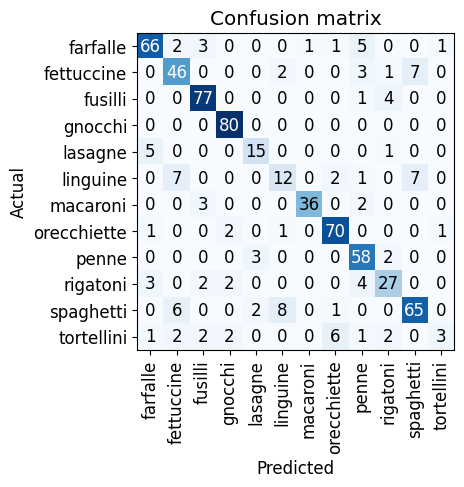

In [17]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()